In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

### Model

In [2]:
# Define the Custom CNN
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(16 * 24 * 24, 32)  # Adjust dimensions after pooling
        self.fc2 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [17]:
class EnhancedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(EnhancedCNN, self).__init__()
        # Convolutional Block 1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  # Increased filters
        self.bn1 = nn.BatchNorm2d(16)  # Batch normalization
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Convolutional Block 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # Increased filters
        self.bn2 = nn.BatchNorm2d(32)
        
        # Convolutional Block 3 (New Layer)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # New layer
        self.bn3 = nn.BatchNorm2d(64)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 12 * 12, 64)  # Adjusted for additional conv layer
        self.dropout = nn.Dropout(0.5)  # Added dropout
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Block 1
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        # Block 2
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        # Block 3
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        # Flatten
        x = x.view(x.size(0), -1)
        # Fully Connected Layers
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


### Load Data

In [3]:
# Transformations for STL-10 dataset
transform = transforms.Compose([
    transforms.Resize((96, 96)),  # Resize to higher resolution
    transforms.ToTensor(),       # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load STL-10 dataset
train_dataset = datasets.STL10(root='./data', split='train', download=True, transform=transform)
test_dataset = datasets.STL10(root='./data', split='test', download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Files already downloaded and verified
Files already downloaded and verified


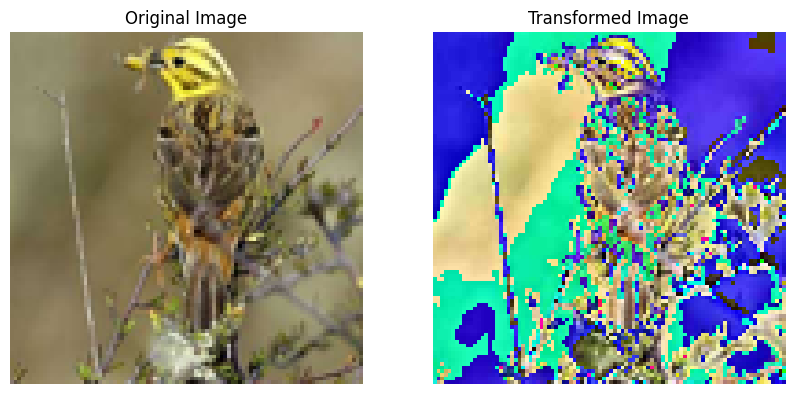

In [52]:
# Transformations for STL-10 dataset
transform = transforms.Compose([
    transforms.Resize((96, 96)),  # Resize to higher resolution
    transforms.ToTensor(),       # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load STL-10 dataset
train_dataset = datasets.STL10(root='./data', split='train', download=True, transform=transform)
test_dataset = datasets.STL10(root='./data', split='test', download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Display an example image before and after transformations
def show_transformed_images(dataset, transform):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Get a random image from the dataset
    image, label = dataset[0]
    
    # Display the original image
    original_image = image.permute(1, 2, 0).numpy()
    original_image = (original_image * 0.5) + 0.5  # De-normalize to [0, 1] range
    axes[0].imshow(original_image)
    axes[0].axis('off')
    axes[0].set_title('Original Image')
    
    # Convert tensor to PIL image
    pil_image = transforms.ToPILImage()(image)
    
    # Apply the transformation and display the transformed image
    transformed_image = transform(pil_image)
    transformed_image = transformed_image.permute(1, 2, 0).numpy()
    transformed_image = (transformed_image * 0.5) + 0.5  # De-normalize to [0, 1] range
    
    axes[1].imshow(transformed_image)
    axes[1].axis('off')
    axes[1].set_title('Transformed Image')
    
    plt.show()

# Show the images
show_transformed_images(train_dataset, transform)

### Train and Test

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training Loop
def train_model_with_loss_plot(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, train_losses=[], val_losses=[]):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Validation step
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_losses.append(val_loss / len(test_loader))

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

    return train_losses, val_losses

# Testing Loop
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total:.2f}%')

In [ ]:
# Model, Loss, Optimizer
model = CNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train and Evaluate
train_losses, val_losses = train_model_with_loss_plot(model, train_loader, test_loader, criterion, optimizer, num_epochs=20, train_losses=[], val_losses=[])
test_model(model, test_loader)

Epoch [1/20], Train Loss: 1.9884, Val Loss: 1.7065
Epoch [2/20], Train Loss: 1.6384, Val Loss: 1.6024
Epoch [3/20], Train Loss: 1.4669, Val Loss: 1.4727
Epoch [4/20], Train Loss: 1.3442, Val Loss: 1.4954
Epoch [5/20], Train Loss: 1.2391, Val Loss: 1.3789
Epoch [6/20], Train Loss: 1.1380, Val Loss: 1.3861
Epoch [7/20], Train Loss: 1.0277, Val Loss: 1.3550
Epoch [8/20], Train Loss: 0.9439, Val Loss: 1.3091


In [ ]:
# Model, Loss, Optimizer
model = EnhancedCNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train and Evaluate
train_losses, val_losses = train_model_with_loss_plot(model, train_loader, test_loader, criterion, optimizer, num_epochs=20, train_losses=[], val_losses=[])
test_model(model, test_loader)

Epoch [1/20], Train Loss: 2.1475, Val Loss: 1.8530
Epoch [2/20], Train Loss: 1.9100, Val Loss: 1.6234
Epoch [3/20], Train Loss: 1.8054, Val Loss: 1.5099
Epoch [4/20], Train Loss: 1.7100, Val Loss: 1.5103
Epoch [5/20], Train Loss: 1.6969, Val Loss: 1.4865
Epoch [6/20], Train Loss: 1.6544, Val Loss: 1.4585
Epoch [7/20], Train Loss: 1.6138, Val Loss: 1.4800
Epoch [8/20], Train Loss: 1.5798, Val Loss: 1.4659
Epoch [9/20], Train Loss: 1.5867, Val Loss: 1.4029
Epoch [10/20], Train Loss: 1.5560, Val Loss: 1.4106
Epoch [11/20], Train Loss: 1.5160, Val Loss: 1.4209
Epoch [12/20], Train Loss: 1.5286, Val Loss: 1.3409
Epoch [13/20], Train Loss: 1.5002, Val Loss: 1.3440
Epoch [14/20], Train Loss: 1.4789, Val Loss: 1.3501
Epoch [15/20], Train Loss: 1.4624, Val Loss: 1.3256
Epoch [16/20], Train Loss: 1.4583, Val Loss: 1.4270
Epoch [17/20], Train Loss: 1.4450, Val Loss: 1.3362
Epoch [18/20], Train Loss: 1.4116, Val Loss: 1.2800
Epoch [19/20], Train Loss: 1.4022, Val Loss: 1.3292
Epoch [20/20], Train 

In [29]:
train_model_with_loss_plot(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, train_losses=train_losses, val_losses=val_losses)
test_model(model, test_loader)

Epoch [1/10], Train Loss: 1.1750, Val Loss: 1.2180
Epoch [2/10], Train Loss: 1.1931, Val Loss: 1.2541
Epoch [3/10], Train Loss: 1.1694, Val Loss: 1.2462
Epoch [4/10], Train Loss: 1.1443, Val Loss: 1.2528
Epoch [5/10], Train Loss: 1.1858, Val Loss: 1.3069
Epoch [6/10], Train Loss: 1.1576, Val Loss: 1.2654
Epoch [7/10], Train Loss: 1.1265, Val Loss: 1.3241
Epoch [8/10], Train Loss: 1.1171, Val Loss: 1.2581
Epoch [9/10], Train Loss: 1.1263, Val Loss: 1.2484
Epoch [10/10], Train Loss: 1.1015, Val Loss: 1.2989
Accuracy: 57.39%


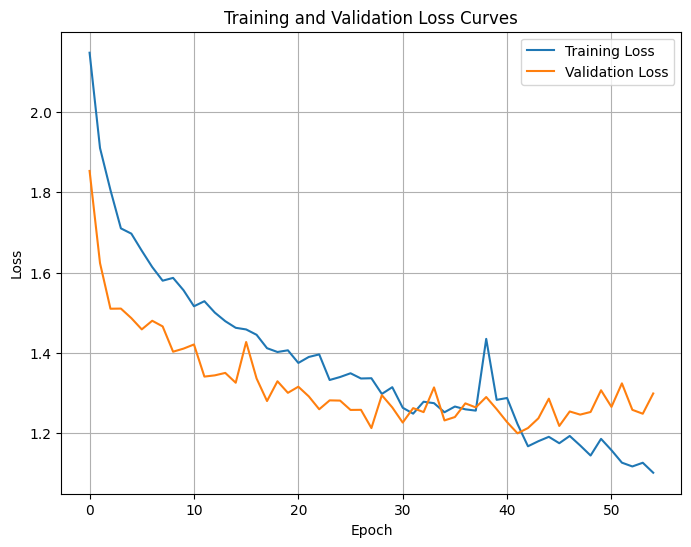

In [30]:
# Function to plot the loss curves
def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid()
    plt.show()

# Plot the curves
plot_loss_curves(train_losses, val_losses)


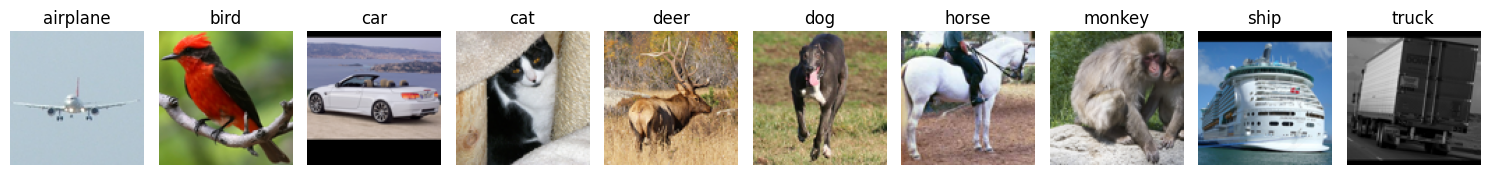

In [44]:
import random
import matplotlib.pyplot as plt

# Class labels for STL-10
classes = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

# Function to display a grid of images, one from each class
def show_images(dataset, classes, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    class_indices = {cls: [] for cls in range(num_images)}
    
    # Collect indices for each class
    for idx, (image, label) in enumerate(dataset):
        if label in class_indices and len(class_indices[label]) < 5:  # Collect up to 5 indices per class
            class_indices[label].append(idx)
        if all(len(indices) >= 5 for indices in class_indices.values()):  # Ensure we have enough images to choose from
            break
    
    for i, (cls, indices) in enumerate(class_indices.items()):
        # Select a random image from the collected indices
        idx = random.choice(indices)
        image, label = dataset[idx]
        image = image.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
        image = (image * 0.5) + 0.5  # De-normalize to [0, 1] range
        
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(classes[label])
    
    plt.tight_layout()
    plt.show()

# Plot class distribution for training and testing datasets
show_images(train_dataset, classes, num_images=10)